In [1]:
#https://www.youtube.com/watch?v=QIUxPv5PJOY&t=2317s&ab_channel=ComputerScience
import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt
import matplotlib.dates
plt.style.use('fivethirtyeight')

import seaborn as sns

In [2]:
#Ucitavanja csv-a i stavljanje da je date kolona index kolona
df = pd.read_csv("TSLA.csv");

#Provera da li ijedna kolona ima null vrednosti
#df.isnull().sum()
#df = df.dropna()

#Konvertovanje podataka kolone Date u Date format
df['Date'] = pd.to_datetime(df.Date)
df

# High = maximalno cena u datom periodu odnosno u danu
# Low = minimalna cena u datom periodu odnosno u danu
# Open = na kojoj ceni je stock poceo na pocetku dana
# Close = na kojoj ceni je stock zavrsion na kraju dana
# Volumen = kolicina koliko je prosla kroz berzu
# Adj Close = podesena cena nakon uracunavanja bilo kakvih korporativnih akcija ( velika kupovina ili tako nesto)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-07-05,6.162000,6.334000,6.160000,6.246000,6.246000,6269000
1,2012-07-06,6.198000,6.346000,6.160000,6.198000,6.198000,3922500
2,2012-07-09,6.188000,6.366000,6.134000,6.298000,6.298000,4552500
3,2012-07-10,6.308000,6.496000,6.178000,6.254000,6.254000,3792000
4,2012-07-11,6.314000,6.336000,6.202000,6.302000,6.302000,3193000
...,...,...,...,...,...,...,...
2510,2022-06-27,748.099976,756.210022,727.700012,734.760010,734.760010,29726100
2511,2022-06-28,733.450012,749.909973,697.030029,697.989990,697.989990,30130400
2512,2022-06-29,691.500000,693.520020,666.820007,685.469971,685.469971,27632400
2513,2022-06-30,673.530029,688.369995,656.590027,673.419983,673.419983,31533500


In [3]:
# df = pd.read_csv("TSLA.csv");

# df['Date'] = pd.to_datetime(df.Date)

# #greater than the start date and smaller than the end date
# mask = (df['Date'] > '2020-07-05')
# test_data = df.loc[mask]
# len(test_data)

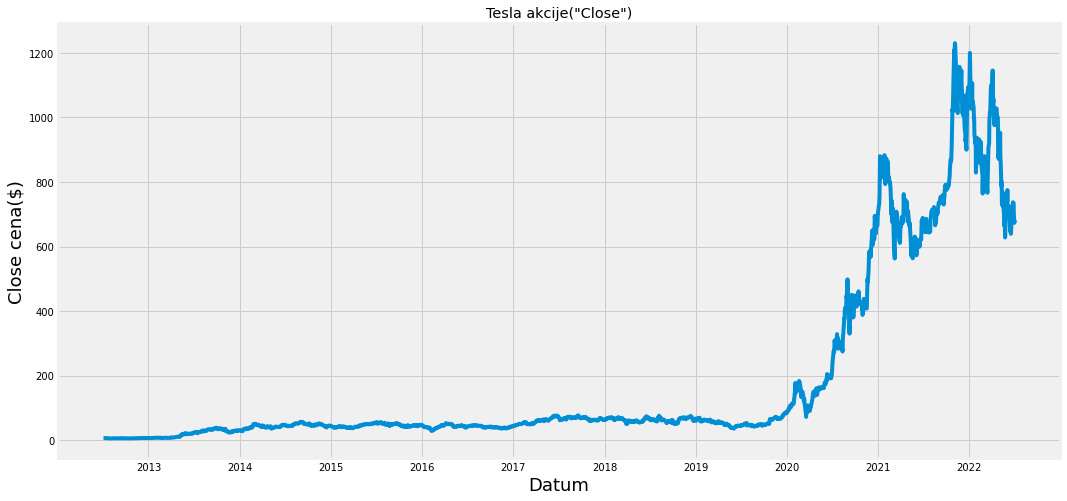

In [4]:
import matplotlib.dates as mdates
#Vizualizacija Close cene akcija

plt.figure(figsize=(16,8))
ax = plt.gca()

#Za formatiranje date kolone da pisu samo godine a ne svaki dan
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

plt.title('Tesla akcije("Close")')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close cena($)', fontsize=18)   

plt.plot(df['Date'], df['Close'])
plt.show()

In [5]:
def scale_data(dataset, scaler):
    #Skaliranje podataka
#     scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(dataset), scaler

def inverse_scale(dataset, scaler):
    #Inverse skaliranje
#     scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.inverse_transform(dataset)

def train_test_split(dataset, split=0.8):
    
    #Broj podataka koji ce biti iskorisceni za treniranje
    training_data_len = math.ceil( len(dataset) * split )
    
    print("Ukupan broj podataka: " + str(len(dataset)))
    print("Train broj podataka: " + str(training_data_len))
    print("Test broj podataka: " + str(len(dataset) - training_data_len))
    
    #Kreira training set podataka
    train_data = dataset[0:training_data_len , :]

    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i,0])
    #     if i<= 61:
    #         print(x_train)
    #         print(y_train)
    #         print()


    #Konvertuje podatke u nparray
    x_train, y_train = np.array(x_train), np.array(y_train)
    print(x_train.shape)
    #Reshape podataka
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape


    #Kreira test set podataka
    test_data = dataset[training_data_len - 60 : , :]

    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])


    #Konvertuje podatke u nparray
    x_test = np.array(x_test)
    #Reshape podataka
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, training_data_len

In [6]:
#MAIN METODA

#Ucitavanje podatak i konverzija Date kolone u datetime tip
df = pd.read_csv("TSLA.csv");
df['Date'] = pd.to_datetime(df.Date)

#Kreira novi dataframe samo sa 'Close' kolonom
data = df.filter(['Close'])

#Konvertira podateke u nparray
dataset = data.values

#Scaler inicijalizacija
scaler = MinMaxScaler(feature_range=(0,1))

#Skaliraj podatke kolone 'Close'
scaled_data, scaler = scale_data(dataset, scaler)

#Train, test split podataka
x_train, y_train, x_test, y_test, training_data_len= train_test_split(scaled_data, split=0.8)

Ukupan broj podataka: 2515
Train broj podataka: 2012
Test broj podataka: 503
(1952, 60)


In [19]:
#Postavljanje LSTM modela

#Model 1
model1 = Sequential()
model1.add(LSTM(55, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model1.add(LSTM(55, return_sequences = False))
#Dodaje dense layere sa 25 i 1 neuronom
model1.add(Dense(25))
model1.add(Dense(1))


#Kompilacija modela
model1.compile(optimizer='adam', loss='mean_squared_error')

#Treniranje modela
model1.fit(x_train, y_train, batch_size=32, epochs=10)

#Sacuvaj istreniran model za ensamble(.hdf5 - ekstenzija da celu mrezu sacuva u jedan fajl)
model1.save('saved_models/model1.hdf5')


#Predvidja cenu na osnovu test skupa
predictions = model1.predict(x_test)
predictions = inverse_scale(predictions, scaler)
# predictions = scaler.inverse_transform(predictions)

#Get rmse
rmse = np.sqrt( np.mean(predictions - y_test) **2)
rmse

Epoch 1/10
61/61 [==============================] - 6s 44ms/step - loss: 1.8767e-04 - acc: 0.0000e+00
Epoch 2/10
61/61 [==============================] - 3s 43ms/step - loss: 2.3995e-05 - acc: 0.0000e+00
Epoch 3/10
61/61 [==============================] - 2s 40ms/step - loss: 2.1155e-05 - acc: 0.0000e+00
Epoch 4/10
61/61 [==============================] - 3s 41ms/step - loss: 2.1262e-05 - acc: 0.0000e+00
Epoch 5/10
61/61 [==============================] - 3s 41ms/step - loss: 1.8905e-05 - acc: 0.0000e+00
Epoch 6/10
61/61 [==============================] - 3s 46ms/step - loss: 1.8193e-05 - acc: 0.0000e+00
Epoch 7/10
61/61 [==============================] - 3s 46ms/step - loss: 1.5686e-05 - acc: 0.0000e+00
Epoch 8/10
61/61 [==============================] - 3s 42ms/step - loss: 1.9502e-05 - acc: 0.0000e+00
Epoch 9/10
61/61 [==============================] - 3s 42ms/step - loss: 1.5032e-05 - acc: 0.0000e+00
Epoch 10/10
16/16 [==============================] - 1s 20ms/step


696.6766216990517

In [ ]:
model1 = load_model('saved_models/model1.hdf5')

prediction1 = model1.predict(x_test)

In [21]:
#Model 2
model2 = Sequential()
model2.add(LSTM(65, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model2.add(Dropout(0.2))
model2.add(LSTM(55, return_sequences = True))
model2.add(Dropout(0.2))
model2.add(LSTM(25))
model2.add(Dense(1))

#Kompilacija modela
model2.compile(optimizer='adam', loss='mean_squared_error')

#Treniranje modela
model2.fit(x_train, y_train, batch_size=32, epochs=10)

#Sacuvaj istreniran model za ensamble
model2.save('saved_models/model2.hdf5')


#Predvidja cenu na osnovu test skupa
predictions = model2.predict(x_test)
predictions = inverse_scale(predictions, scaler)
# predictions = scaler.inverse_transform(predictions)

#Get rmse
rmse = np.sqrt( np.mean(predictions - y_test) **2)
rmse

Epoch 1/10
61/61 [==============================] - 10s 79ms/step - loss: 2.0252e-04
Epoch 2/10
61/61 [==============================] - 5s 88ms/step - loss: 4.8392e-05
Epoch 3/10
61/61 [==============================] - 5s 84ms/step - loss: 3.4577e-05
Epoch 4/10
61/61 [==============================] - 5s 88ms/step - loss: 3.2840e-05
Epoch 5/10
61/61 [==============================] - 5s 82ms/step - loss: 3.1643e-05
Epoch 6/10
61/61 [==============================] - 5s 75ms/step - loss: 2.6676e-05
Epoch 7/10
61/61 [==============================] - 5s 77ms/step - loss: 3.0908e-05
Epoch 8/10
61/61 [==============================] - 5s 79ms/step - loss: 2.6178e-05
Epoch 9/10
61/61 [==============================] - 5s 77ms/step - loss: 2.2315e-05
Epoch 10/10
16/16 [==============================] - 2s 30ms/step


782.8009788580994

In [23]:
#Model 3
model3 = Sequential()
model3.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model3.add(Dropout(0.2))
model3.add(LSTM(50, return_sequences = True))
model3.add(Dropout(0.2))
model3.add(LSTM(50, return_sequences = True))
model3.add(Dropout(0.2))
model3.add(LSTM(50))
model3.add(Dropout(0.2))
model3.add(Dense(1))

#Kompilacija modela
model3.compile(optimizer='adam', loss='mean_squared_error')

#Treniranje modela
model3.fit(x_train, y_train, batch_size=32, epochs=10)

#Sacuvaj istreniran model za ensamble
model3.save('saved_models/model3.hdf5')


#Predvidja cenu na osnovu test skupa
predictions = model3.predict(x_test)
predictions = inverse_scale(predictions, scaler)
# predictions = scaler.inverse_transform(predictions)

#Get rmse
rmse = np.sqrt( np.mean(predictions - y_test) **2)
rmse

Epoch 1/10
61/61 [==============================] - 11s 90ms/step - loss: 3.4310e-04
Epoch 2/10
61/61 [==============================] - 5s 89ms/step - loss: 8.3553e-05
Epoch 3/10
61/61 [==============================] - 5s 88ms/step - loss: 7.3824e-05
Epoch 4/10
61/61 [==============================] - 6s 93ms/step - loss: 7.1538e-05
Epoch 5/10
61/61 [==============================] - 6s 96ms/step - loss: 5.9656e-05
Epoch 6/10
61/61 [==============================] - 5s 89ms/step - loss: 4.9810e-05
Epoch 7/10
61/61 [==============================] - 5s 88ms/step - loss: 4.5408e-05
Epoch 8/10
61/61 [==============================] - 5s 88ms/step - loss: 4.8388e-05
Epoch 9/10
61/61 [==============================] - 5s 88ms/step - loss: 5.3285e-05
Epoch 10/10
16/16 [==============================] - 2s 40ms/step


725.0374970960835

In [148]:
from keras.models import load_model

model1 = load_model('saved_models/model1.hdf5')
model2 = load_model('saved_models/model2.hdf5')
model3 = load_model('saved_models/model3.hdf5')

prediction1 = model1.predict(x_test)
prediction2 = model2.predict(x_test)
prediction3 = model3.predict(x_test)

prediction1 = inverse_scale(prediction1, scaler)
prediction2 = inverse_scale(prediction2, scaler)
prediction3 = inverse_scale(prediction3, scaler)

accuracy1 = np.sqrt( np.mean(prediction1 - y_test) **2)
accuracy2 = np.sqrt( np.mean(prediction2 - y_test) **2)
accuracy3 = np.sqrt( np.mean(prediction3 - y_test) **2)


models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

for idx, x in enumerate(preds):
    preds[idx] = inverse_scale(preds[idx], scaler)
    
weights = [0.3, 1, 1]

#Sabira resenja sve tri liste i pomnozi ih sa weightsom
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))

#Podeli sa brojem modela svaku kolonu da se dobije mean
weighted_preds = [element/len(models) for element in weighted_preds]


#weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = np.sqrt( np.mean(weighted_preds - y_test) **2)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
# print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

16/16 [==============================] - 1s 40ms/step
Accuracy Score for model1 =  696.6766216990517
Accuracy Score for model2 =  782.8009788580994
Accuracy Score for model3 =  725.0374970960835
Accuracy Score for weighted average ensemble =  734.8383658844115


In [146]:
a = [[[1],[2],[3],[4]], [[5],[6],[7],[8]], [[9],[10],[11],[12]]]  
weights1 = [0.1, 0.2, 0.3]
weights2 = [1,1,1]
weighted_preds1 = np.tensordot(a, weights2, axes=((0),(0)))


# random = 0
# for idx,value in enumerate(a):
#     a[idx] = random
#     random += 1
    
weighted_preds1 = [element/3 for element in weighted_preds1]
weighted_preds1
#[15], [18],  [21],  [24]

#[3.8],  [4.4],  [5. ], [5.6]]
# 1*0.1 + 5*0.2 + 9*0.3 = 3.8
# preds[0]
#a[0]
# weighted_ensemble_prediction = np.argmax(a, axis=0)
# weighted_ensemble_prediction

[array([5.]), array([6.]), array([7.]), array([8.])]

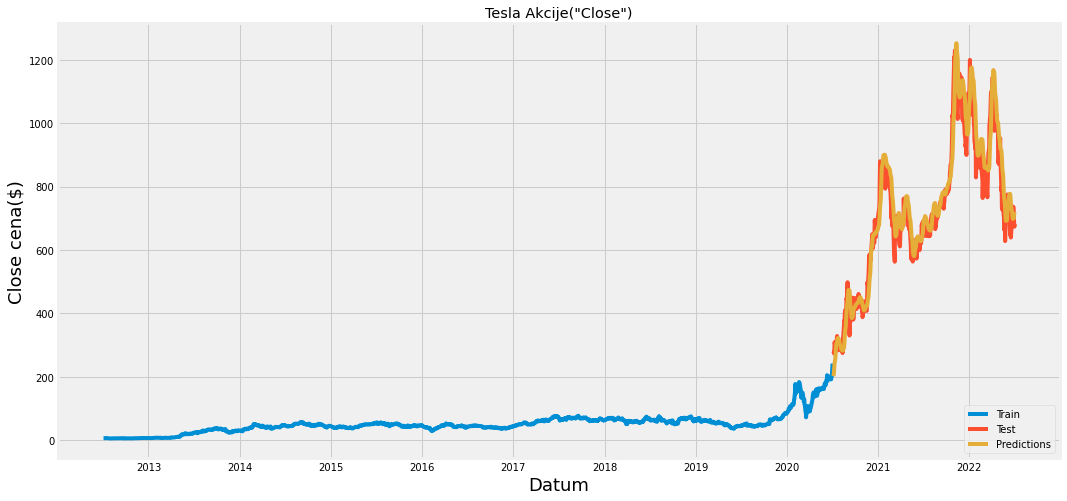

In [149]:
#Plot the results
train = data[:training_data_len]
data_date = df.filter(['Date'])
train['Datum'] = data_date[:training_data_len]

valid = data[training_data_len:]
valid['Predictions'] = weighted_preds#predictions
valid['Datum'] = data_date[training_data_len:]
# train['Datum'] = df['Date']

#Visualize the data
plt.figure(figsize=(16,8))
ax = plt.gca()
#Za formatiranje date kolone da pisu samo godine a ne svaki dan
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

plt.title('Tesla Akcije("Close")')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close cena($)', fontsize=18)

plt.plot(train['Datum'], train['Close'])
plt.plot(valid['Datum'], valid[['Close', 'Predictions']])

plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#DERN: Deep Ensemble Learning Model for Short- and Long-Term Prediction of Baltic Dry Index
# https://www.researchgate.net/publication/339456466_DERN_Deep_Ensemble_Learning_Model_for_Short-_and_Long-Term_Prediction_of_Baltic_Dry_Index

#Youtube tutorial ensamble deep learning
#https://www.youtube.com/watch?v=-ix_Mjzu8BU&ab_channel=DigitalSreeni

#Bagging, Boosting, Stacking modeli ensambla objasnjeni
#https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205